# Toric Code

## Introduction

The toric code is a topological quantum error correcting code, and an example of a stabilizer code, defined on a two-dimensional spin lattice. It is the simplest and most well studied of the quantum double models [\[2\]](https://arxiv.org/abs/cond-mat/0506438). It is also the simplest example of topological order—Z2 topological order (first studied in the context of Z2 spin liquid in 1991)[\[3\]](https://ui.adsabs.harvard.edu/abs/1991PhRvL..66.1773R)[\[4\]](https://doi.org/10.1103%2Fphysrevb.44.2664). The toric code can also be considered to be a Z2 lattice gauge theory in a particular limit [\[5\]](https://doi.org/10.1103%2Fphysrevd.19.3682). It was introduced by Alexei Kitaev.

The toric code gets its name from its periodic boundary conditions, giving it the shape of a torus. These conditions give the model translational invariance, which is useful for analytic study. However, some experimental realizations require open boundary conditions, allowing the system to be embedded on a 2D surface. The resulting code is typically known as the planar code. This has identical behaviour to the toric code in most, but not all, cases.

<div align = "center">
    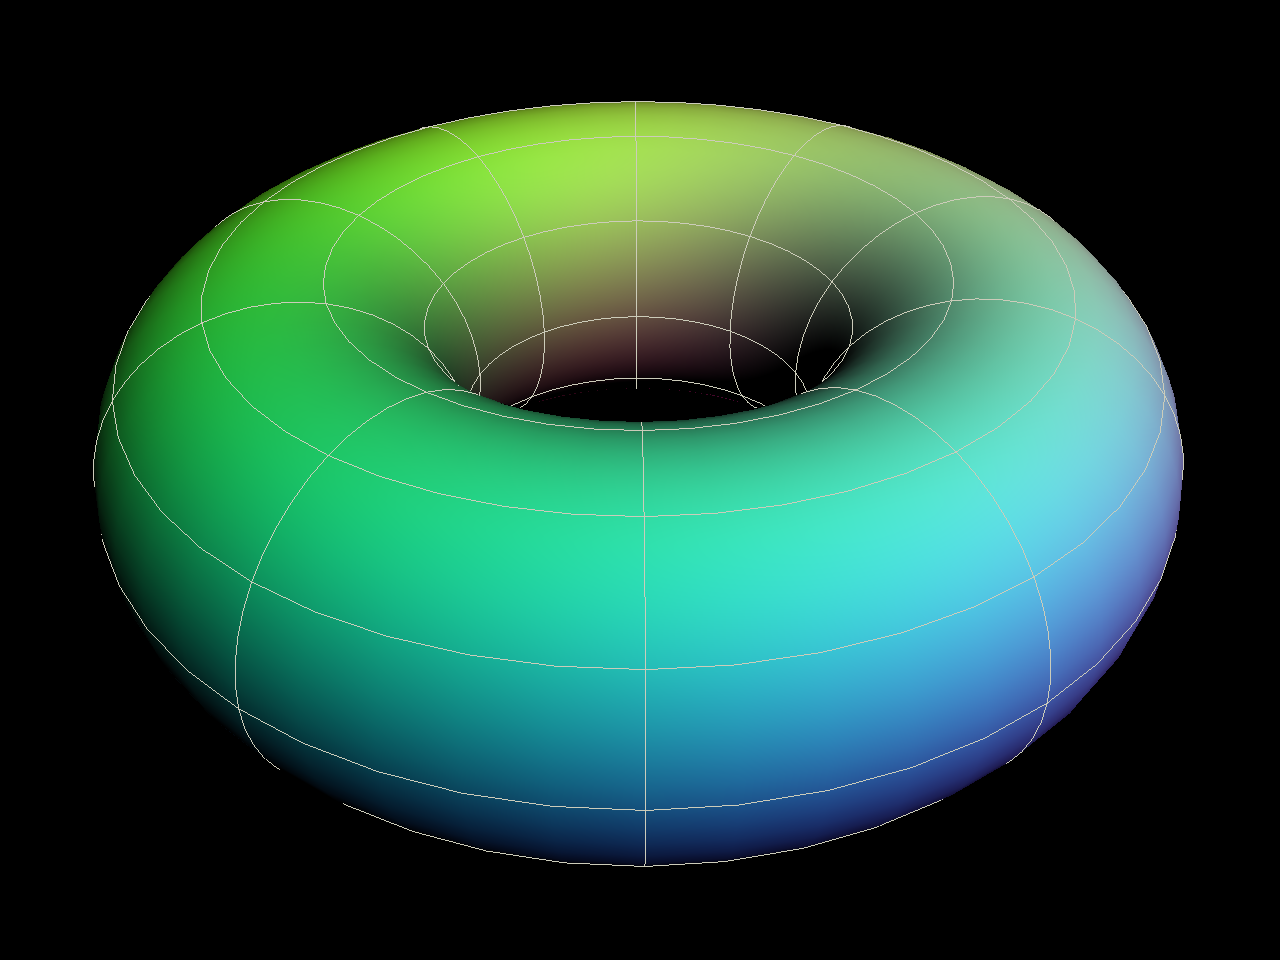
</div>

The toric code is defined on a two-dimensional lattice, with periodic boundary conditions. The stablizers give us the hamiltonian:
$$ H = -\sum_v A_v - \sum_p B_p $$
where
$$ A_v = \prod_{e \in n(v)} X_e \;\;\;\; B_p = \prod_{e \in p} Z_p $$
n(v) means the edges connected to the vertex v, and p is a face. 

In this code, we will work with Bombin's lattice (checkerboard type). Here, each square will have either type-X stabilizer (A_v) or type-Z stabilizer (B_p) with qubits on the vertices instead. This is equivalent to the toric code defined previously.
<div align = "center">
    <img src = "toric_code_checker.svg" width = "500"/>
</div>

For the purposes of this notebook, the code will only run for even height and even width. The obstruction is creation of ground state, in particular the order in which one has to apply the X stabilizers. 

For more information, see [Pennylane Toric Code](https://pennylane.ai/qml/demos/tutorial_toric_code/)

## Importing libraries

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Patch
from itertools import product
from dataclasses import dataclass

import numpy as np

## Setting up the lattice

In [2]:
np.set_printoptions(suppress = True)

# Make sure the height and width are even numbers
height = 6
width = 4

# In this formalism, the width and height needs to be even to make sure
# that the stabilizers commute. For odd case, the stabilizers on the boundary 
# that intersect once are of different types and therefore can never commute

# Create a list of all sites on the lattice grid
all_sites = [(i, j) for i, j in product(range(width), range(height))]

# Create wire class that can represent wire labels by row and column positions
@dataclass(frozen=True)
class Wire:
    i: int
    j: int


# example_wire = Wire(0, 0)
# print("At coordinates: ", example_wire.i, example_wire.j)

## Creating Stabilizers

In [3]:
# Create a function that helps with the periodicity of the lattice
mod = lambda s: Wire(s[0] % width, s[1] % height)

# First we add all the z stabilizers
zstab_sites = []  # list of location of qubits in each stabilizer
zstab_ops = []  # list of operators for each stabilizer

# Iterate over the width and height
for x, y in product(range(width // 2), range(height)):

    x0 = 2 * x + (y + 1) % 2 # starting x-coordinate

    sites = [(x0, y), (x0 + 1, y), (x0 + 1, y + 1), (x0, y + 1)] # anti-clockwise from the bottom left vertex

    op = qml.operation.Tensor(*(qml.PauliZ(mod(s)) for s in sites)) # tensor product of operators for stabilizers

    zstab_sites.append(sites)
    zstab_ops.append(op)

print("First set of sites: ", zstab_sites[0])
print("First operator: ", zstab_ops[0])

First set of sites:  [(1, 0), (2, 0), (2, 1), (1, 1)]
First operator:  Z(Wire(i=1, j=0)) @ Z(Wire(i=2, j=0)) @ Z(Wire(i=2, j=1)) @ Z(Wire(i=1, j=1))


In [4]:
# Now we add the X-stabilizers. Note that this will be used to create the ground state
# So the order is important.
xstab_sites = []
xstab_ops = []

# Iterate over width and height
for x, y in product(range(width//2), range(height)):
    
    x0 = 2 * x + y % 2 # lower x coordinate

    sites = [(x0 + 1, y + 1), (x0, y + 1), (x0, y), (x0 + 1, y)] # anti-clockwise from the top right vertex

    if x0==width -1 and y<height-1:  # change order for faces that are on the right boundary
        sites = sites[1:] + sites[0:1] # send the top-right corner to the end
        
    op = qml.operation.Tensor(*(qml.PauliX(mod(s)) for s in sites)) # tensor product of operators for stabilizers

    xstab_sites.append(sites)
    xstab_ops.append(op)

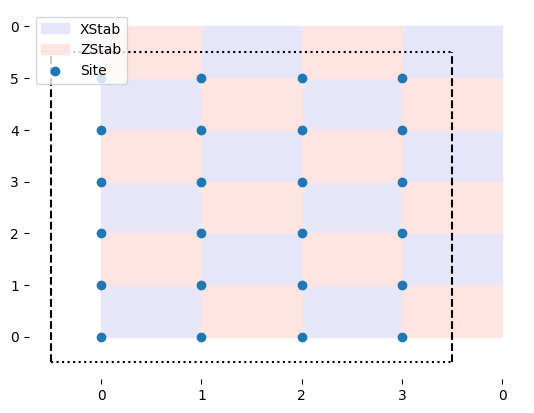

In [5]:
# We draw the lattice with stabilizers color coded
# We start with X stabilizer in the bottom left corner
def misc_plot_formatting(fig, ax):
    plt.hlines([-0.5, height - 0.5], -0.5, width - 0.5, linestyle="dotted", color="black")
    plt.vlines([-0.5, width - 0.5], -0.5, height - 0.5, linestyle="dashed", color="black")
    plt.xticks(range(width + 1), [str(i % width) for i in range(width + 1)])
    plt.yticks(range(height + 1), [str(i % height) for i in range(height + 1)])

    for direction in ["top", "right", "bottom", "left"]:
        ax.spines[direction].set_visible(False)

    return fig, ax


fig, ax = plt.subplots()
fig, ax = misc_plot_formatting(fig, ax)

for group in xstab_sites:
    x_patch = ax.add_patch(Polygon(group, color="lavender", zorder=0))

for group in zstab_sites:
    z_patch = ax.add_patch(Polygon(group, color="mistyrose", zorder=0))

plt_sites = ax.scatter(*zip(*all_sites))

plt.legend([x_patch, z_patch, plt_sites], ["XStab", "ZStab", "Site"], loc="upper left")

plt.show()

In [6]:
# Using lightning qubit for computations
dev = qml.device("lightning.qubit", wires=[Wire(*s) for s in all_sites])

# Prepare the ground state using X stabilizers
def state_prep():
    for op in xstab_ops[0:-1]:
        # Apply Hadamard on the first qubit in the stabilizer
        qml.Hadamard(op.wires[0])
        for w in op.wires[1:]:
            # Apply CNOT from the first qubit to other qubits in the stabilizer
            qml.CNOT(wires=[op.wires[0], w])


@qml.qnode(dev, diff_method=None)

# Create the circuit
def circuit():
    state_prep()

    # return the expected value for each stabilizers
    return [qml.expval(op) for op in xstab_ops + zstab_ops]
    
n_xstabs = len(xstab_ops)
# Separate expected values into X stabilizer and Z stabilizer expected values
separate_expvals = lambda expvals: (expvals[:n_xstabs], expvals[n_xstabs:])

xstab_expvals, zstab_expvals = separate_expvals(circuit())

# Calculate the ground state energy for the hamiltonian
E0 = -sum(xstab_expvals) - sum(zstab_expvals)

# Each stabilizer should have 1 as expected value in the ground state
print("X Stabilizer expectation values", [np.round(val) for val in xstab_expvals])
print("Z Stabilizer expectation values", [np.round(val) for val in zstab_expvals])
print("Total energy: ", E0)

X Stabilizer expectation values [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Z Stabilizer expectation values [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Total energy:  -24.0


## Excitations

The excitations are always created in pairs. Acting on any qubit by a Z gate will create two excitations in the lavender faces. Similarly, acting on a qubit by a X gate will create two excitations in the mistyrose faces. 

Note that excitation corresponds to an increase in the energy.

One can create a string of these excitations where the number of errors remain two for any connected string. Let's look at an example

In [7]:
@qml.qnode(dev, diff_method=None)
def excitations(x_sites, z_sites):
    '''
    x_sites: (row,col) # location to add X operator
    z_sites: (row,col) # location to add Z operator
    returns: expected value of the stabilizers
    '''

    # prepare the ground state
    state_prep()

    # add X operators on the sites 
    for s in x_sites:
        qml.PauliX(Wire(*s))

    # add Z operators on the sites
    for s in z_sites:
        qml.PauliZ(Wire(*s))

    # return the expected value of the stabilizers
    return [qml.expval(op) for op in xstab_ops + zstab_ops]

# Creating a single X excitation
single_x = [(1, 2)]

x_expvals, z_expvals = separate_expvals(excitations(single_x, []))

print("XGroup: ", [np.round(val) for val in x_expvals])
print("ZGroup: ", [np.round(val) for val in z_expvals])

XGroup:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ZGroup:  [1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [8]:
# We look at a different way of expressing the existence of the quasi particles. 
# The location where the expval is -1, we set it to 1, otherwise 0.

occupation_numbers = lambda expvals: [0.5 * (1 - np.round(val)) for val in expvals]

def print_info(x_expvals, z_expvals):
    E = -sum(x_expvals) - sum(z_expvals)

    print("Total energy: ", E)
    print("Energy above the ground state: ", E - E0)
    print("X Group occupation numbers: ", occupation_numbers(x_expvals))
    print("Z Group occupation numbers: ", occupation_numbers(z_expvals))

print_info(x_expvals, z_expvals)

Total energy:  -20.0
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


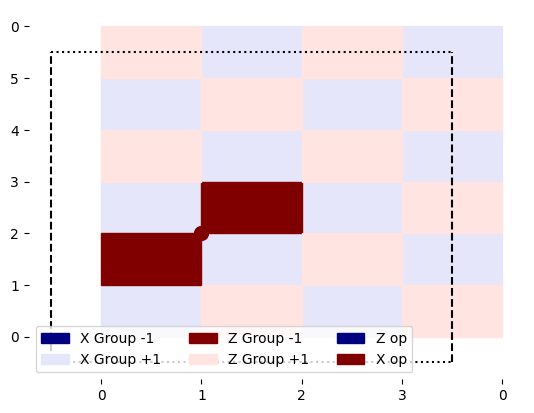

In [9]:
# We can also plot the excitations
def excitation_plot(x_excite, z_excite):
    x_color = lambda expval: "navy" if expval < 0 else "lavender"
    z_color = lambda expval: "maroon" if expval < 0 else "mistyrose"

    fig, ax = plt.subplots()
    fig, ax = misc_plot_formatting(fig, ax)

    for expval, sites in zip(x_excite, xstab_sites):
        ax.add_patch(Polygon(sites, color=x_color(expval), zorder=0))

    for expval, sites in zip(z_excite, zstab_sites):
        ax.add_patch(Polygon(sites, color=z_color(expval), zorder=0))

    handles = [
        Patch(color="navy", label="X Group -1"),
        Patch(color="lavender", label="X Group +1"),
        Patch(color="maroon", label="Z Group -1"),
        Patch(color="mistyrose", label="Z Group +1"),
        Patch(color="navy", label="Z op"),
        Patch(color="maroon", label="X op"),
    ]

    plt.legend(handles=handles, ncol=3, loc="lower left")

    return fig, ax

fig, ax = excitation_plot(x_expvals, z_expvals)
ax.scatter(*zip(*single_x), color="maroon", s=100)
plt.show()

Total energy:  -20.0
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


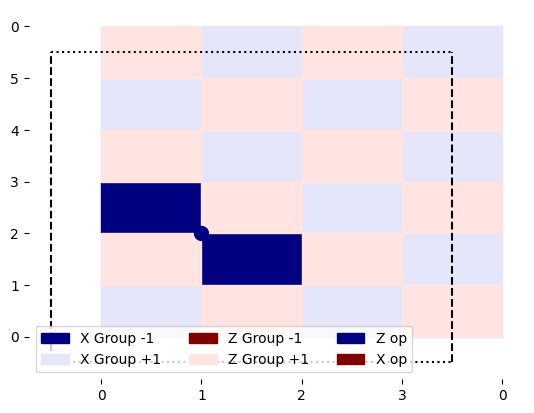

In [10]:
# Creating a Z excitation now
single_z = [(1, 2)]

expvals = excitations([], single_z)
x_expvals, z_expvals = separate_expvals(expvals)
print_info(x_expvals, z_expvals)
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.scatter(*zip(*single_z), color="navy", s=100)
plt.show()

## Moving excitations

Total energy:  -20.0
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


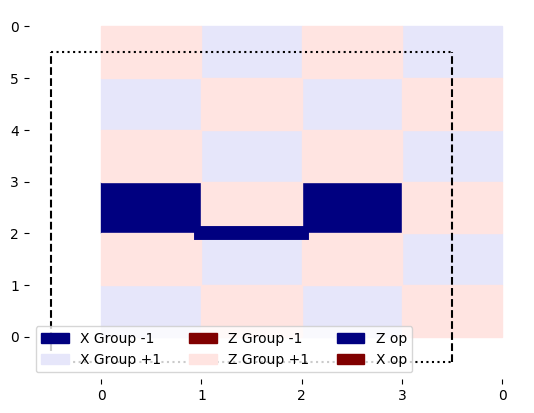

In [11]:
two_z = [(1, 2), (2, 2)]

expvals = excitations([], two_z)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*two_z), color="navy", linewidth=10)
plt.show()

## Move it further

Total energy:  -20.0
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


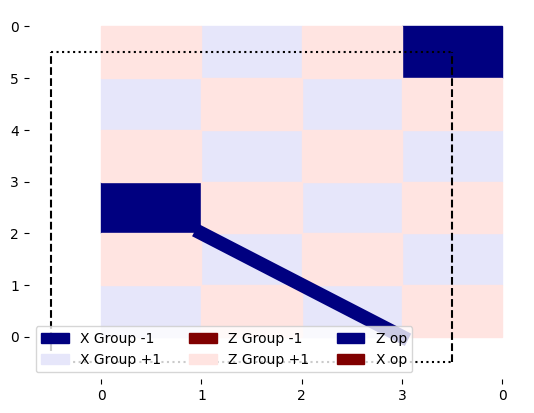

In [12]:
long_string = [(1, 2), (2,1), (3, 0)]

expvals = excitations([], long_string)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*long_string), color="navy", linewidth=10)
plt.show()

Total energy:  -24.0
Energy above the ground state:  0.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


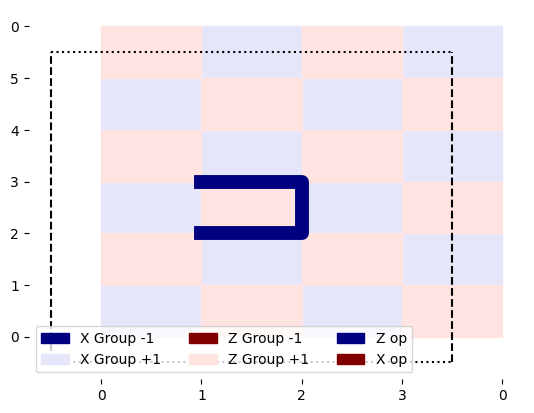

In [13]:
con_string = [(1, 2), (2,2),(2,3),(1,3)]

expvals = excitations([], con_string)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*con_string), color="navy", linewidth=10)
plt.show()

## Non-contractible loops

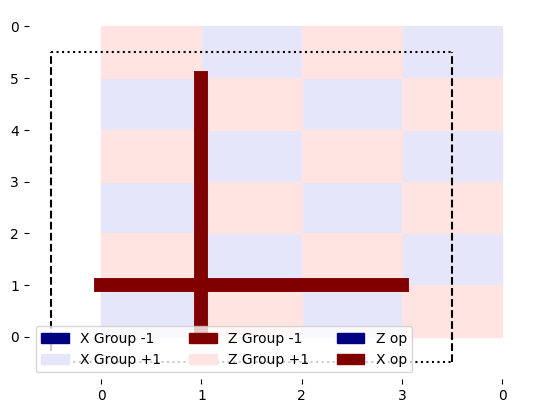

In [14]:
horizontal_loop = [(i, 1) for i in range(width)]
vertical_loop = [(1, i) for i in range(height)]

expvals = excitations(horizontal_loop + vertical_loop, [])
fig, ax = excitation_plot(*separate_expvals(expvals))

ax.plot(*zip(*horizontal_loop), color="maroon", linewidth=10)
ax.plot(*zip(*vertical_loop), color="maroon", linewidth=10)

plt.show()

In [15]:
expvals = excitations([], horizontal_loop)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -24.0
Energy above the ground state:  0.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Trying one qubit gate

## Lets try RX gate

In [16]:
@qml.qnode(dev, diff_method=None)
def ang_excitations(x_site, x_angle,width,height,q):
    '''
    x_angle: For RX gate
    returns: expected value of the stabilizers
    '''

    # prepare the ground state
    state_prep()

    # add RX operators on the site
    w_x = Wire(*x_site)
    qml.RX(x_angle, wires = w_x)
    if q==1:
        for k in range(width-1):
            cq = Wire((w_x.i+k+1)%width, w_x.j)
            qml.CNOT(wires = [w_x, cq])
            
    elif q==2:
        for k in range(height-1):
            cq = Wire(w_x.i, (w_x.j+k+1)%height)
            qml.CNOT(wires = [w_x, cq])
    # return the expected value of the stabilizers
    return [qml.expval(op) for op in xstab_ops + zstab_ops]

# Creating a single X excitation
single_x = (1, 2)

x_expvals, z_expvals = separate_expvals(ang_excitations(single_x,np.pi/2 ,width, height, 1))

print("XGroup: ", [np.round(val) for val in x_expvals])
print("ZGroup: ", [np.round(val) for val in z_expvals])
print_info(x_expvals, z_expvals)

XGroup:  [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ZGroup:  [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Total energy:  -20.0
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [20]:
@qml.qnode(dev, diff_method=None)
def ang_excitations(x_site, x_angle,width,height,q):
    '''
    x_angle: For RX gate
    returns: expected value of the stabilizers
    '''

    # prepare the ground state
    state_prep()

    # add RX operators on the site
    w_x = Wire(*x_site)
    qml.RX(x_angle, wires = w_x)
    if q==1:
        for k in range(width-1):
            cq = Wire((w_x.i+k+1)%width, w_x.j)
            qml.CNOT(wires = [w_x, cq])
    elif q==2:
        for k in range(height-1):
            cq = Wire(w_x.i, (w_x.j+k+1)%height)
            qml.CNOT(wires = [w_x, cq])
    
    # return the expected value of the stabilizers
    return [qml.expval(op) for op in xstab_ops + zstab_ops]

# Creating a single X excitation
single_x = (1, 2)

x_expvals, z_expvals = separate_expvals(ang_excitations(single_x,np.pi,width, height, 1))

print("XGroup: ", [np.round(val) for val in x_expvals])
print("ZGroup: ", [np.round(val) for val in z_expvals])
print_info(x_expvals, z_expvals)

XGroup:  [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ZGroup:  [1.0, -0.0, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Total energy:  -20.0
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
